In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Introduction

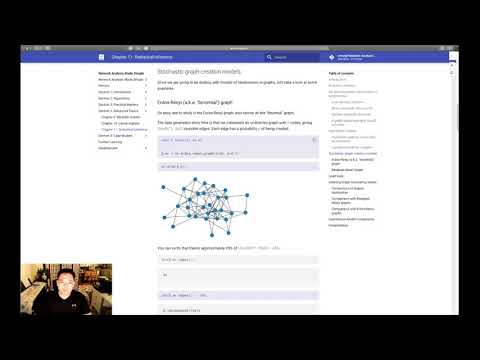

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="P-0CJpO3spg", width="100%")

In this chapter, we are going to take a look at how to perform statistical inference on graphs.

## Statistics refresher

Before we can proceed with statistical inference on graphs,
we must first refresh ourselves with some ideas from the world of statistics.
Otherwise, the methods that we will end up using
may seem a tad _weird_, and hence difficult to follow along.

To review statistical ideas,
let's set up a few statements and explore what they mean.

## We are concerned with models of randomness

As with all things statistics, we are concerned with models of randomness.
Here, probability distributions give us a way to think about random events
and how to assign credibility points to them.

### In an abstract fashion...

The supremely abstract way of thinking about a probability distribution
is that it is the space of all possibilities of "stuff"
with different credibility points _distributed_ amongst each possible "thing".

### More concretely: the coin flip

A more concrete example is to consider the coin flip.
Here, the space of all possibilities of "stuff" is the set of "heads" and "tails".
If we have a fair coin, then we have 0.5 credibility points _distributed_
to each of "heads" and "tails".

### Another example: dice rolls

Another concrete example is to consider the six-sided dice.
Here, the space of all possibilities of "stuff" is the set of numbers in the range $[1, 6]$.
If we have a fair dice, then we have 1/6 credibility points assigned
to each of the numbers.
(Unfair dice will have an unequal _distribution_ of credibility points across each face.)

### A graph-based example: social networks

If we receive an undirected social network graph with 5 nodes and 6 edges,
we have to keep in mind that this graph with 6 edges
was merely one of $15 \choose 6$ ways to construct 5 node, 6 edge graphs.
(15 comes up because there are 15 edges that can be constructed in a 5-node undirected graph.)

## Hypothesis Testing

A commonplace task in statistical inferences
is calculating the probability of observing a value or something more extreme
under an assumed "null" model of reality.
This is what we commonly call "hypothesis testing",
and where the oft-misunderstood term "p-value" shows up.

### Hypothesis testing in coin flips, by simulation

As an example, hypothesis testing in coin flips follows this logic:

- I observe that 8 out of 10 coin tosses give me heads, giving me a probability of heads $p=0.8$ (a summary statistic).
- Under a "null distribution" of a fair coin, I simulate the distribution of probability of heads (the summary statistic) that I would get from 10 coin tosses.
- Finally, I use that distribution to calculate the probability of observing $p=0.8$ or more extreme.

### Hypothesis testing in graphs

The same protocol applies when we perform hypothesis testing on graphs.

Firstly, we calculate a _summary statistic_ that describes our graph.

Secondly, we propose a _null graph model_, and calculate our summary statistic under simulated versions of that null graph model.

Thirdly, we look at the probability of observing the summary statistic value that we calculated in step 1 or more extreme, under the assumed graph null model distribution.

## Stochastic graph creation models

Since we are going to be dealing with models of randomness in graphs,
let's take a look at some examples.

### Erdos-Renyi (a.k.a. "binomial") graph

On easy one to study is the Erdos-Renyi graph, also known as the "binomial" graph.

The data generation story here is that we instantiate an undirected graph with $n$ nodes,
giving $\frac{n^2 - n}{2}$ possible edges.
Each edge has a probability $p$ of being created.

In [11]:
import networkx as nx
import numpy as np

G_er = nx.erdos_renyi_graph(n=30, p=0.2)

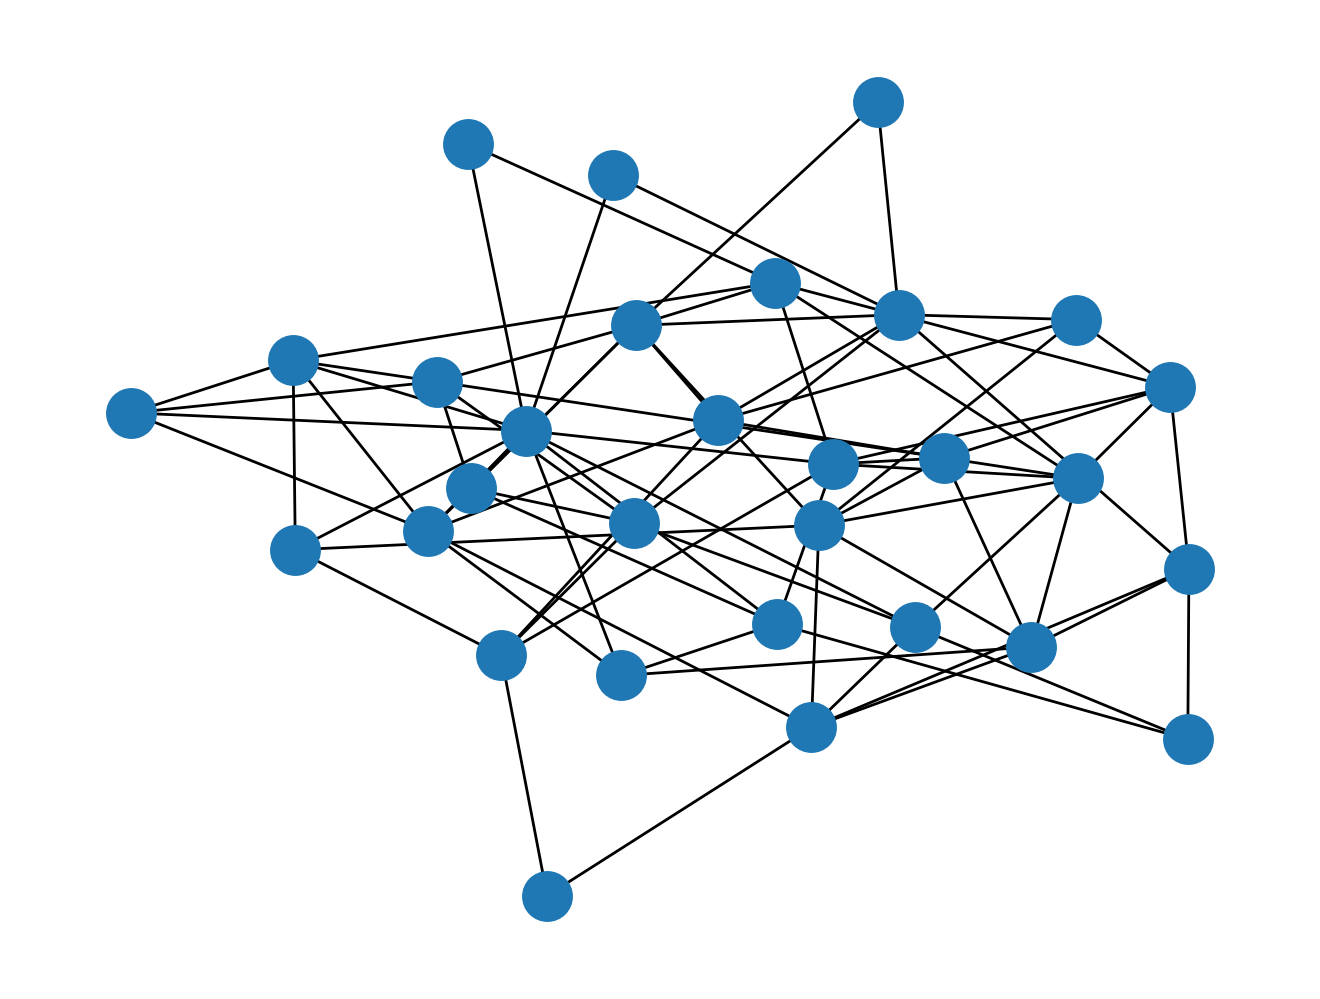

In [12]:
nx.draw(G_er)

You can verify that there's approximately 20% of $\frac{30^2 - 30}{2} = 435$.

In [13]:
len(G_er.edges())

79

In [14]:
len(G_er.edges()) / 435

0.18160919540229886

We can also look at the degree distribution:

In [15]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

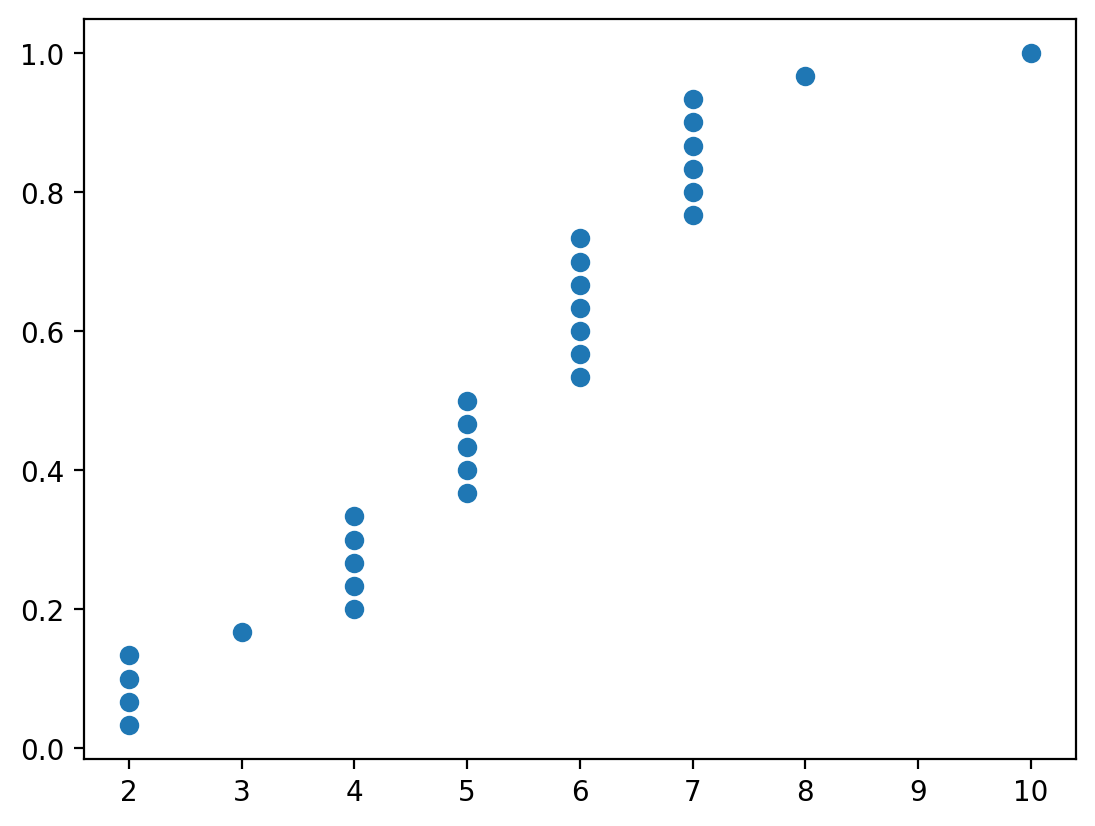

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

x, y = ecdf(pd.Series(dict(nx.degree(G_er))))
plt.scatter(x, y)

### Barabasi-Albert Graph

The data generating story of this graph generator is essentially that nodes that have lots of edges preferentially get new edges attached onto them. 
This is what we call a "preferential attachment" process.

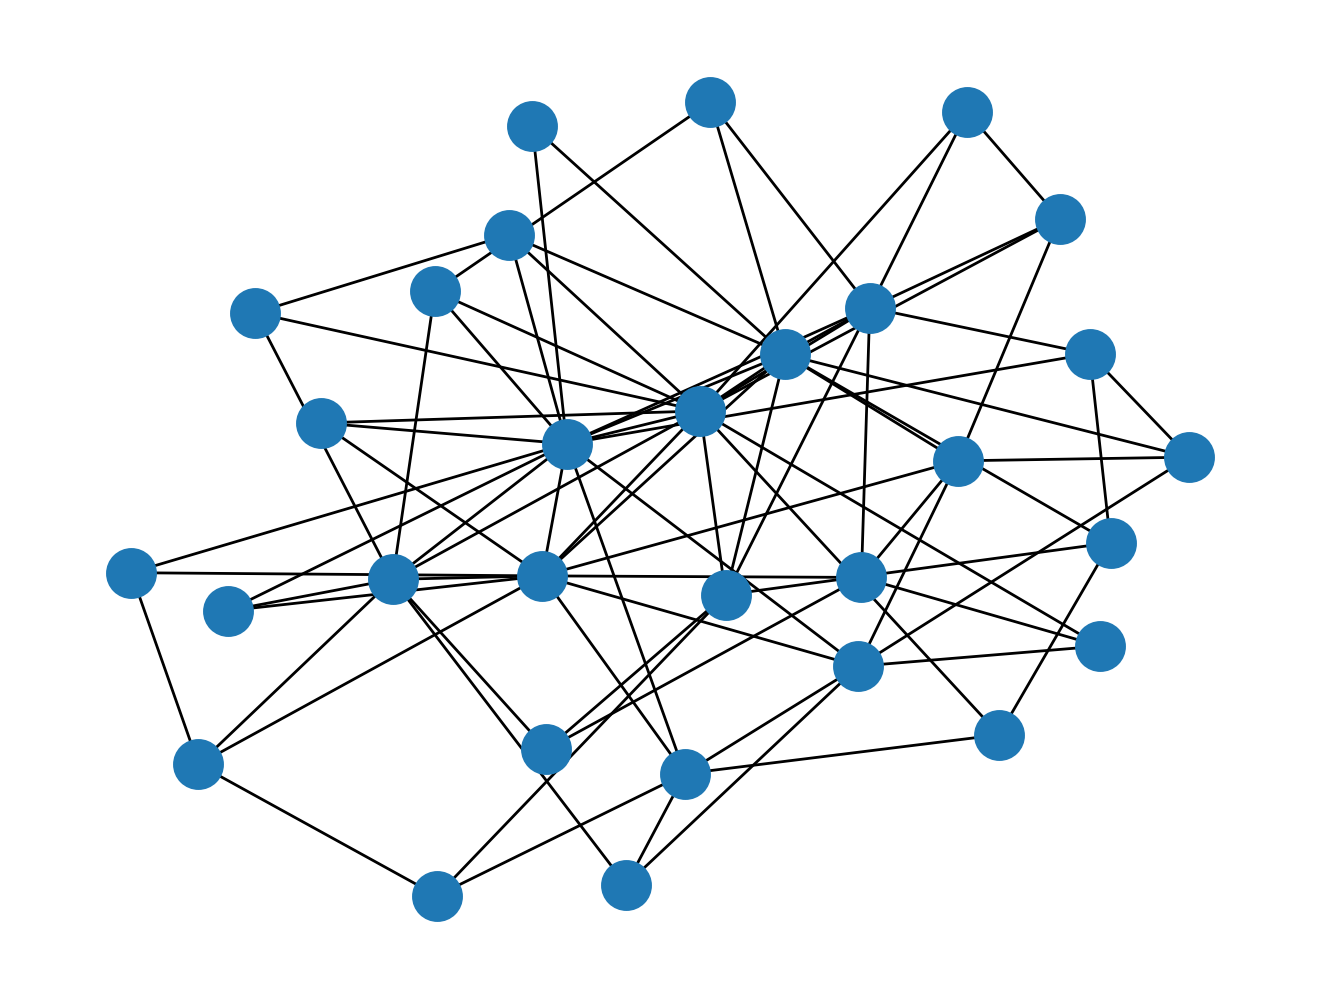

In [17]:
G_ba = nx.barabasi_albert_graph(n=30, m=3)
nx.draw(G_ba)

In [18]:
len(G_ba.edges())

81

And the degree distribution:

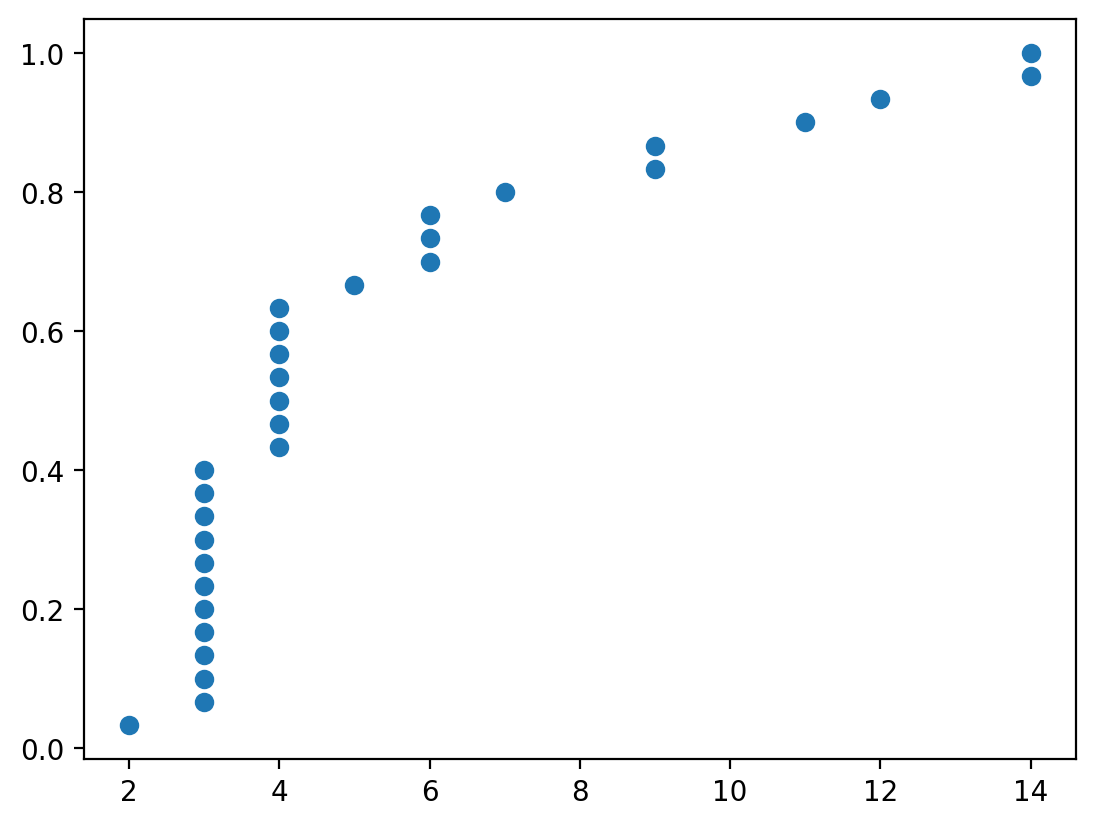

In [19]:
x, y = ecdf(pd.Series(dict(nx.degree(G_ba))))
plt.scatter(x, y)

You can see that even though the number of edges between the two graphs are similar,
their degree distribution is wildly different.

## Load Data

For this notebook, we are going to look at a protein-protein interaction network,
and test the hypothesis that this network was _not_ generated by the data generating process
described by an Erdos-Renyi graph.

Let's load a [protein-protein interaction network dataset](http://konect.cc/networks/moreno_propro).

> This undirected network contains protein interactions contained in yeast.
> Research showed that proteins with a high degree
> were more important for the surivial of the yeast than others.
> A node represents a protein and an edge represents a metabolic interaction between two proteins. 
> The network contains loops.

In [44]:
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

propro = pd.read_csv(
    "https://raw.githubusercontent.com/ericmjl/Network-Analysis-Made-Simple/master/data/moreno_propro/out.moreno_propro_propro.txt",
    skiprows=2,
    header=None,
    delimiter=" ",
)
propro.columns = ["prot1_id", "prot2_id"]
G = nx.Graph()
G.add_edges_from(zip(propro["prot1_id"], propro["prot2_id"]))

for n, d in G.nodes(data=True):
    G.nodes[n]["degree"] = G.degree(n)

As is always the case, let's make sure we know some basic stats of the graph.

In [21]:
len(G.nodes())

1870

In [22]:
len(G.edges())

2277

Let's also examine the degree distribution of the graph.

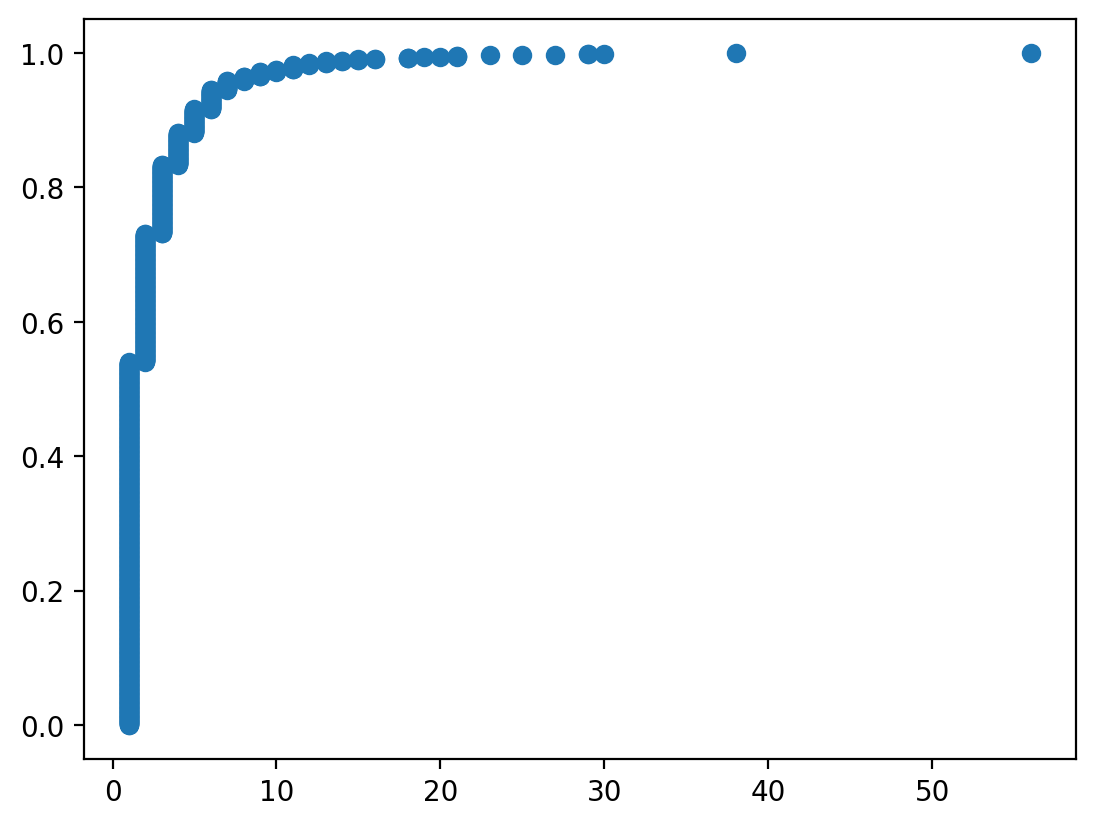

In [23]:
x, y = ecdf(pd.Series(dict(nx.degree(G))))
plt.scatter(x, y)

Finally, we should visualize the graph to get a feel for it.

In [24]:
!pip install nxviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


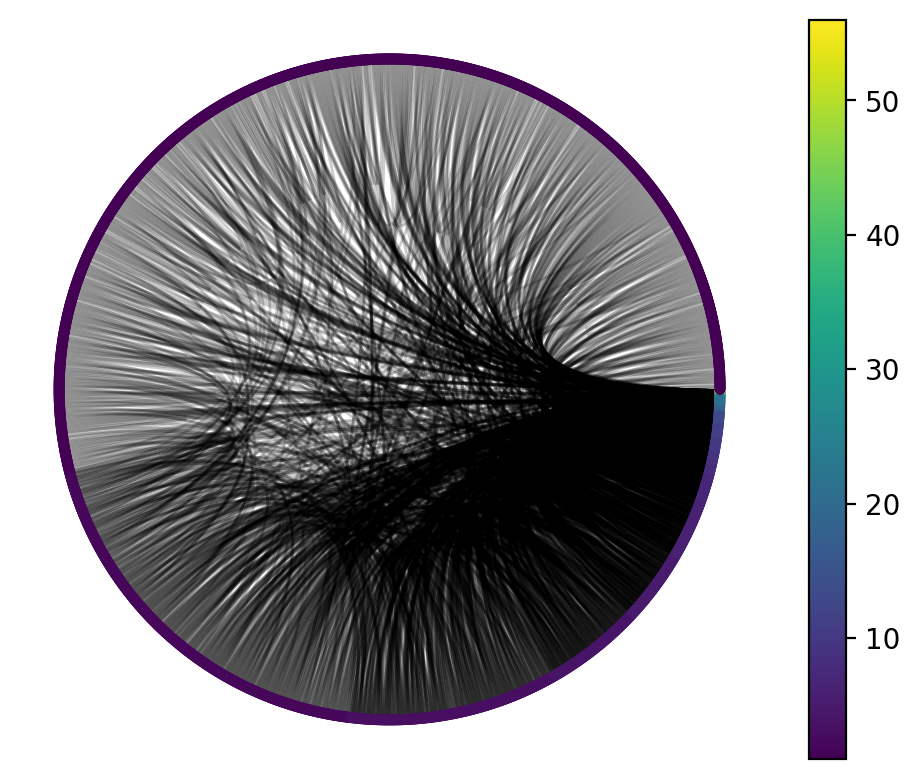

In [46]:
import nxviz as nv
from nxviz import annotate

nv.circos(G, sort_by="degree", node_color_by="degree", node_enc_kwargs={"size_scale": 10})
annotate.node_colormapping(G, color_by="degree")

One thing we might infer from this visualization
is that the vast majority of nodes have a very small degree,
while a very small number of nodes have a high degree.
That would prompt us to think:
what process could be responsible for generating this graph?

## Inferring Graph Generating Model

Given a graph dataset, how do we identify which data generating model provides the best fit?

One way to do this is to compare characteristics of a graph generating model against the characteristics of the graph.
The logic here is that if we have a good graph generating model for the data,
we should, in theory, observe the observed graph's characteristics
in the graphs generated by the graph generating model.

### Comparison of degree distribution

Let's compare the degree distribution between the data, a few Erdos-Renyi graphs, and a few Barabasi-Albert graphs.

### Comparison with Barabasi-Albert graphs

interactive(children=(IntSlider(value=2, description='m', max=10, min=1), Output()), _dom_classes=('widget-int…

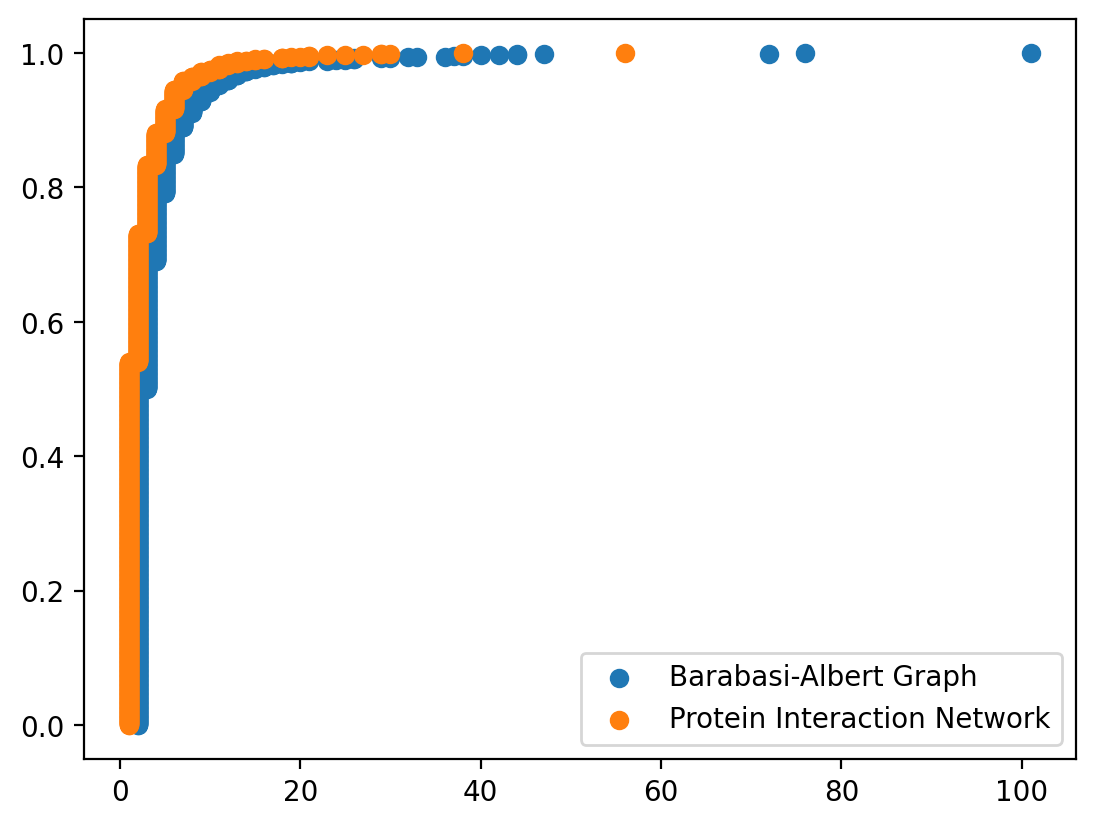

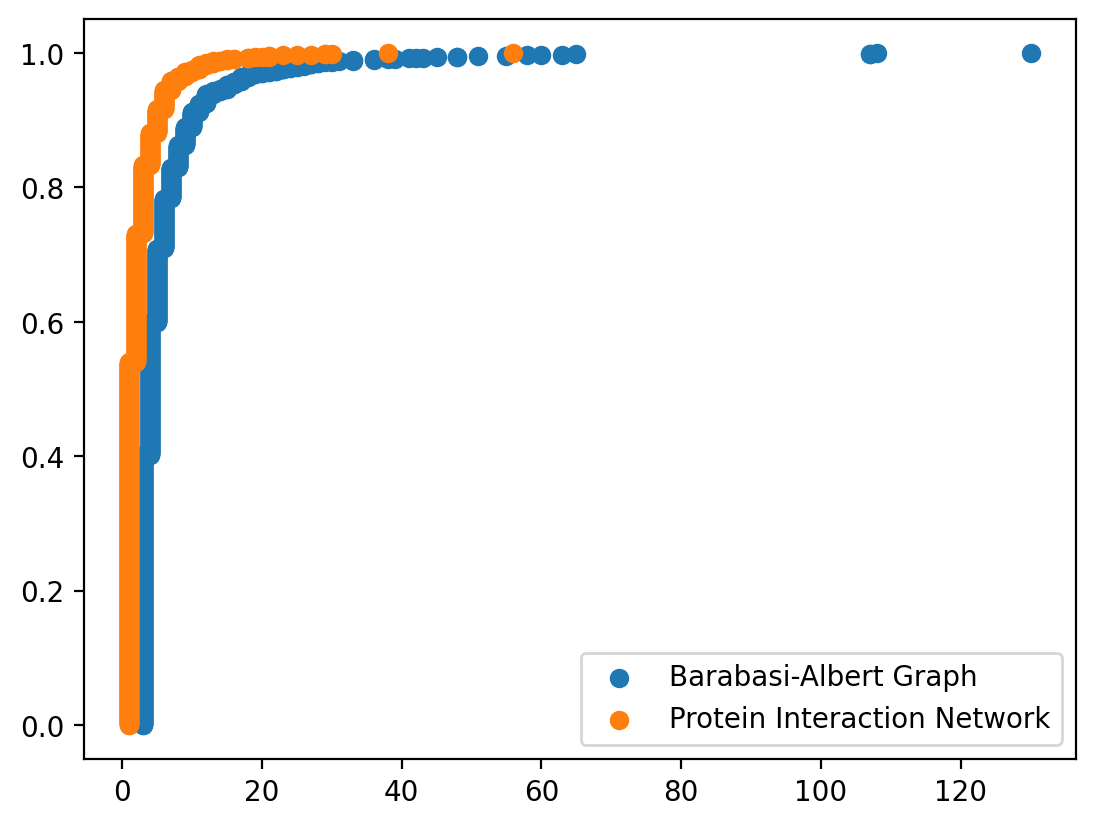

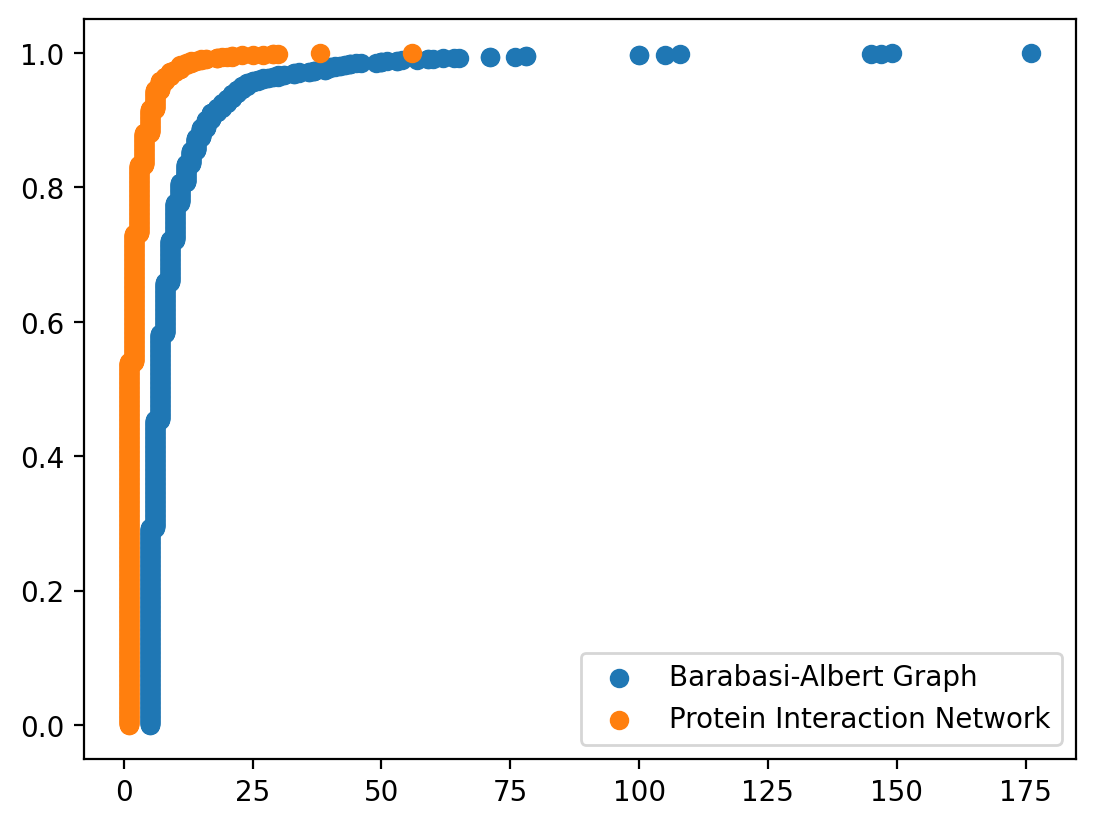

In [47]:
from ipywidgets import interact, IntSlider

m = IntSlider(value=2, min=1, max=10)

@interact(m=m)
def compare_barabasi_albert_graph(m):
    fig, ax = plt.subplots()
    G_ba = nx.barabasi_albert_graph(n=len(G.nodes()), m=m)
    x, y = ecdf(pd.Series(dict(nx.degree(G_ba))))
    ax.scatter(x, y, label="Barabasi-Albert Graph")
    
    x, y = ecdf(pd.Series(dict(nx.degree(G))))
    ax.scatter(x, y, label="Protein Interaction Network")
    ax.legend()

### Comparison with Erdos-Renyi graphs

interactive(children=(FloatSlider(value=0.1, description='p', max=0.1, step=0.001), Output()), _dom_classes=('…

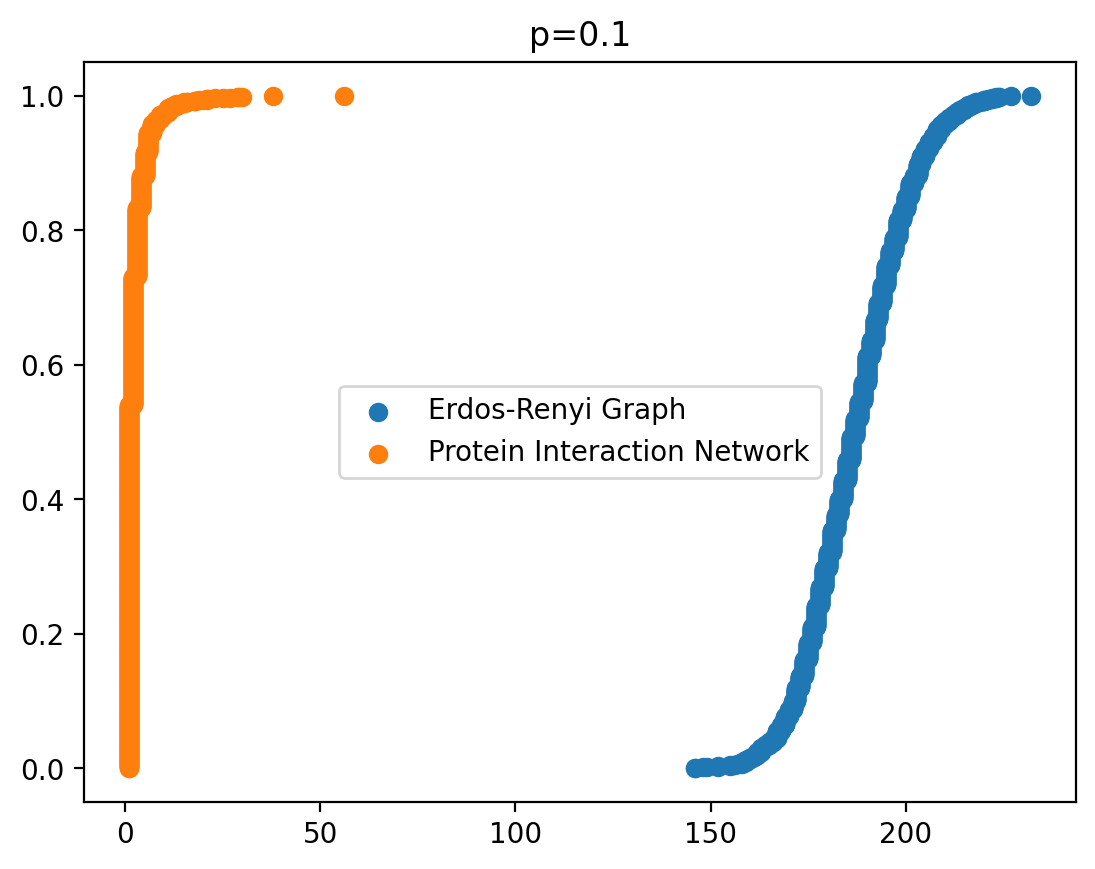

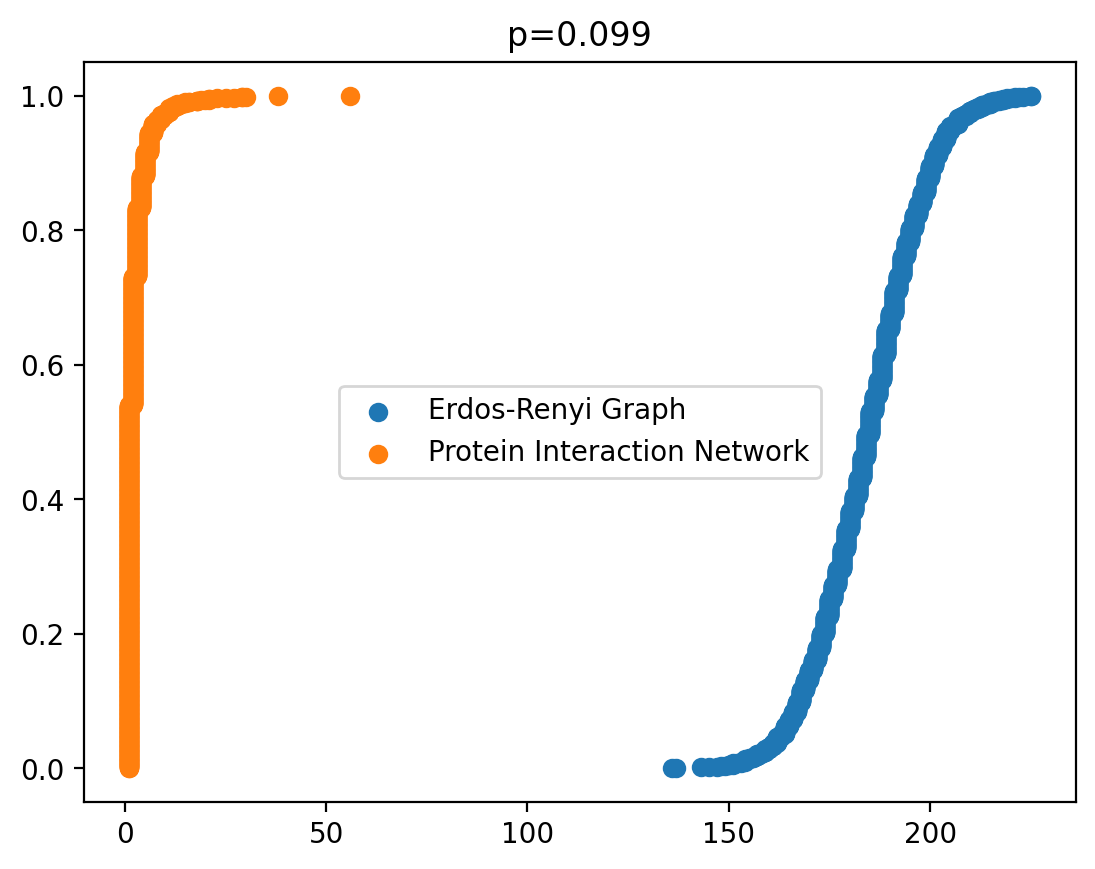

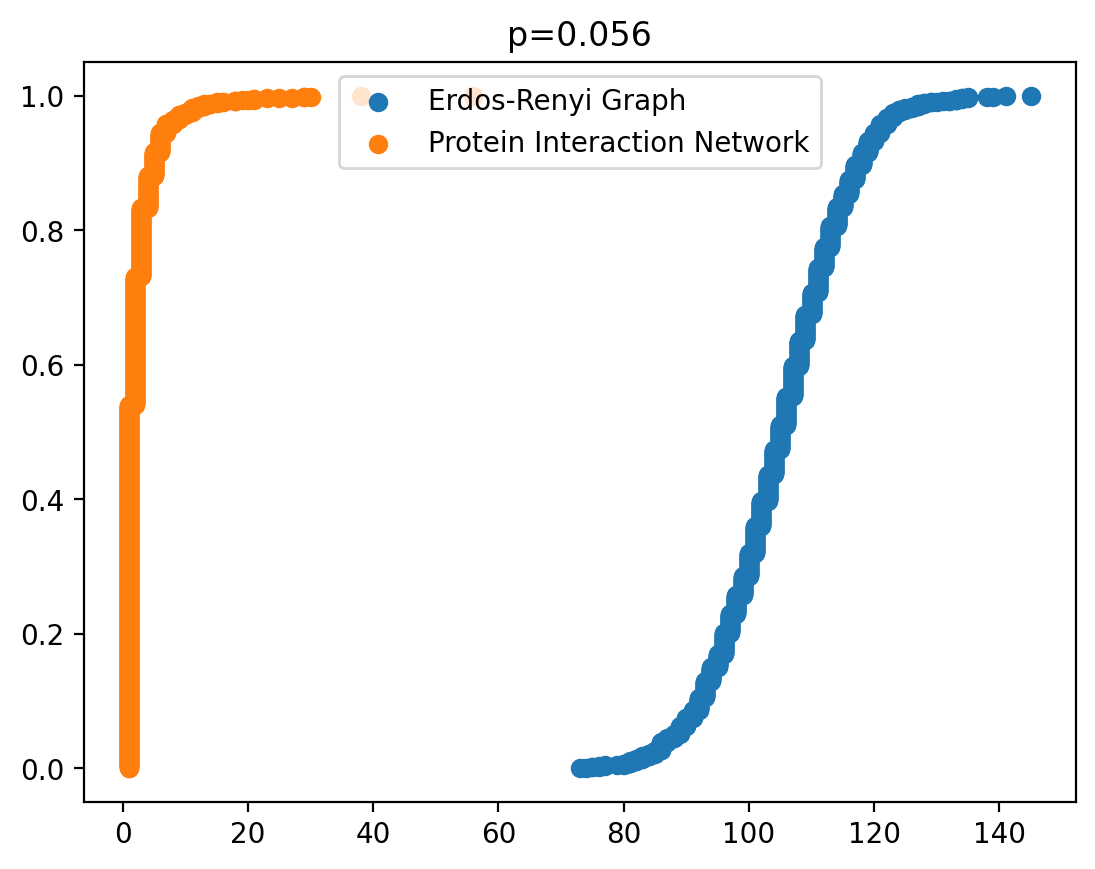

In [48]:
from ipywidgets import FloatSlider
p = FloatSlider(value=0.6, min=0, max=0.1, step=0.001)

@interact(p=p)
def compare_erdos_renyi_graph(p):
    fig, ax = plt.subplots()
    G_er = nx.erdos_renyi_graph(n=len(G.nodes()), p=p)
    x, y = ecdf(pd.Series(dict(nx.degree(G_er))))
    ax.scatter(x, y, label="Erdos-Renyi Graph")
    
    x, y = ecdf(pd.Series(dict(nx.degree(G))))
    ax.scatter(x, y, label="Protein Interaction Network")
    ax.legend()
    ax.set_title(f"p={p}")

Given the degree distribution only, which model do you think better describes the generation of a protein-protein interaction network?

## Quantitative Model Comparison

Each time we plug in a value of $m$ for the Barabasi-Albert graph model, we are using one of many possible Barabasi-Albert graph models, each with a different $m$.
Similarly, each time we choose a different $p$ for the Erdos-Renyi model, we are using one of many possible Erdos-Renyi graph models, each with a different $p$.

To quantitatively compare degree distributions, we can use the [Wasserstein distance][wasd] between the data.
Let's see how to implement this.

[wasd]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [49]:
from scipy.stats import wasserstein_distance

def erdos_renyi_degdist(n, p):
    """Return a Pandas series of degree distribution of an Erdos-Renyi graph."""
    G = nx.erdos_renyi_graph(n=n, p=p)
    return pd.Series(dict(nx.degree(G)))

def barabasi_albert_degdist(n, m):
    """Return a Pandas series of degree distribution of an Barabasi-Albert graph."""
    G = nx.barabasi_albert_graph(n=n, m=m)
    return pd.Series(dict(nx.degree(G)))

In [50]:
deg = pd.Series(dict(nx.degree(G)))

er_deg = erdos_renyi_degdist(n=len(G.nodes()), p=0.001)
ba_deg = barabasi_albert_degdist(n=len(G.nodes()), m=1)
wasserstein_distance(deg, er_deg), wasserstein_distance(deg, ba_deg)

(0.7882352941176467, 0.49304812834224543)

Notice that because the graphs are instantiated in a non-deterministic fashion, re-running the cell above will give you different values for each new graph generated.

Let's now plot the wasserstein distance to our graph data for the two particular Erdos-Renyi and Barabasi-Albert graph models shown above.

In [51]:
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

er_dist = []
ba_dist = []
for _ in tqdm(range(100)):
    er_deg = erdos_renyi_degdist(n=len(G.nodes()), p=0.001)
    er_dist.append(wasserstein_distance(deg, er_deg))
    

    ba_deg = barabasi_albert_degdist(n=len(G.nodes()), m=1)
    ba_dist.append(wasserstein_distance(deg, ba_deg))

# er_degs = [erdos_renyi_degdist(n=len(G.nodes()), p=0.001) for _ in range(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
!pip install janitor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.9 MB/s eta 0:00:00
  Created wheel for janitor: filename=Janitor-0.1.1-py3-none-any.whl size=3809 sha256=9ba4c63e12c4b6b91a1512e0f02a2dbbfd33e72b5d7a7cbbe60924e3c8a90c60
  Stored in directory: /root/.cache/pip/wheels/46/09/c4/04f1ce068cf653251d33e020080654539d3459cc52b07ce6fc
Successfully built janitor


In [56]:
import seaborn as sns
import janitor


data = (
    pd.DataFrame(
        {
            "Erdos-Renyi": er_dist,
            "Barabasi-Albert": ba_dist,
        }
    )
    .melt(value_vars=["Erdos-Renyi", "Barabasi-Albert"])
    .rename_columns({"variable": "Graph Model", "value": "Wasserstein Distance"})
)
sns.swarmplot(data=data, x="Graph Model", y="Wasserstein Distance")

ModuleNotFoundError: ignored

From this, we might conclude that the Barabasi-Albert graph with $m=1$ has the better fit to the protein-protein interaction network graph.

## Interpretation

That statement, accurate as it might be, still does not connect the dots to _biology_.

Let's think about the generative model for this graph.
The Barabasi-Albert graph gives us a model for "rich gets richer".
Given the current state of the graph,
if we want to add a new edge, we first pick a node with probability proportional to
the number of edges it already has.
Then, we pick another node with probability proportional to the number of edges that it has too.
Finally, we add an edge there.
This has the effect of "enriching" nodes that have a large number of edges with more edges.

How might this connect to biology?

We can't necessarily provide a concrete answer, but this model might help raise new hypotheses.

For example, if protein-protein interactions of the "binding" kind
are driven by subdomains, then proteins that acquire a domain through recombination
may end up being able to bind to everything else that the domain was able to.
In this fashion, proteins with that particular binding domain
gain new edges more readily.

Testing these hypotheses would be a totally different matter, and at this point,
I submit the above hypothesis with a large amount of salt thrown over my shoulder.
In other words, the hypothesized mechanism could be completely wrong.
However, I hope that this example illustrated that
the usage of a "graph generative model" can help us narrow down hypotheses about the observed world.

# K-core decomposition


In [57]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [58]:
G0 = nx.Graph()
list_edges = [('a', 'd'), ('d', 'i'), ('g', 'h'), ('f', 'h'), ('b', 'e'), 
              ('c', 'e'), ('e', 'i'), ('h', 'j'), ('j', 'n'), ('h', 'i'),
              ('i', 'l'), ('l', 'n'), ('n', 'o'), ('l', 'o'), ('l', 'k'), 
              ('k', 'n'), ('o', 'k'), ('k', 'u'), ('m', 'u'), ('l', 'm'), 
              ('o', 'p'), ('k', 'p'), ('k', 's'), ('u', 's'), ('s', 'r'), 
              ('s', 'q'), ('s', 'p'), ('s', 'n'), ('s', 'o')]
G0.add_edges_from(list_edges)

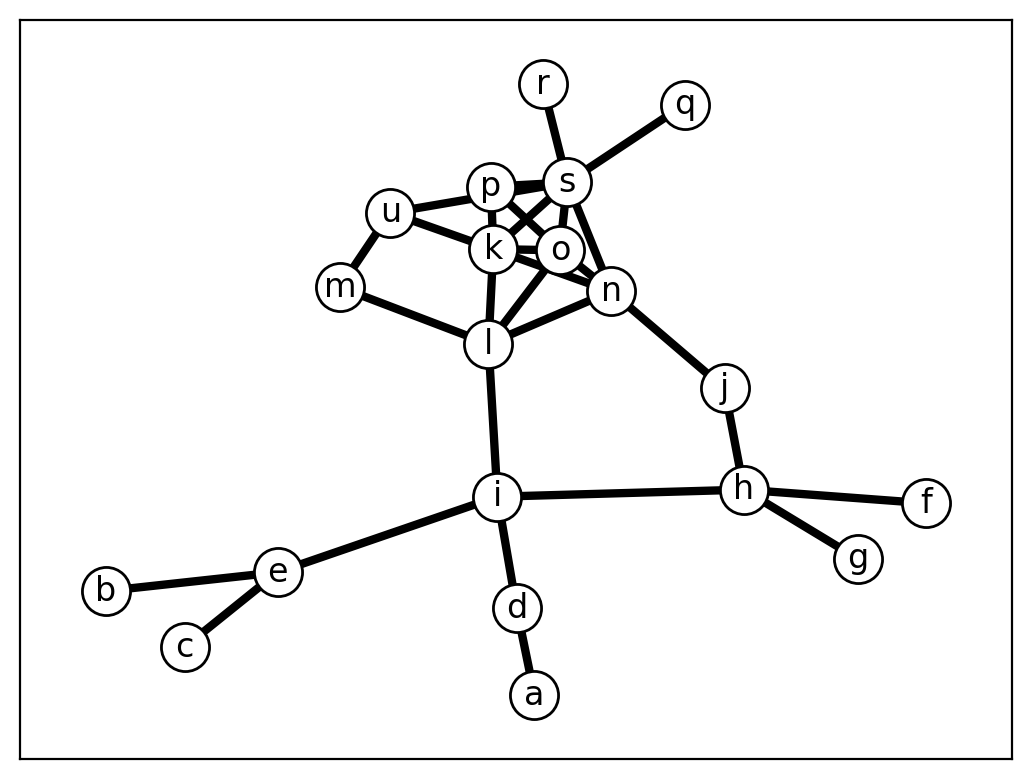

In [59]:
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 3,
}
nx.draw_networkx(G0, **options)

In [61]:
core = 0
for i in nx.k_core(G0, core):
  print(i)

a
d
i
g
h
f
b
e
c
j
n
l
o
k
u
m
p
s
r
q


In [62]:
# How many k-cores does this network have?
set([v for k,v in nx.core_number(G0).items()])

{1, 2, 3}

In [64]:
list(nx.k_shell(G0, 1))

['a', 'q', 'b', 'r', 'g', 'c', 'e', 'd', 'f']

In [63]:
list(nx.k_shell(G0, 2))

['h', 'i', 'm', 'u', 'j']

In [65]:
list(nx.k_shell(G0, 3))

['p', 'n', 'l', 'k', 'o', 's']

In [ ]:
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 3,
}
nx.draw_networkx(G0, **options)

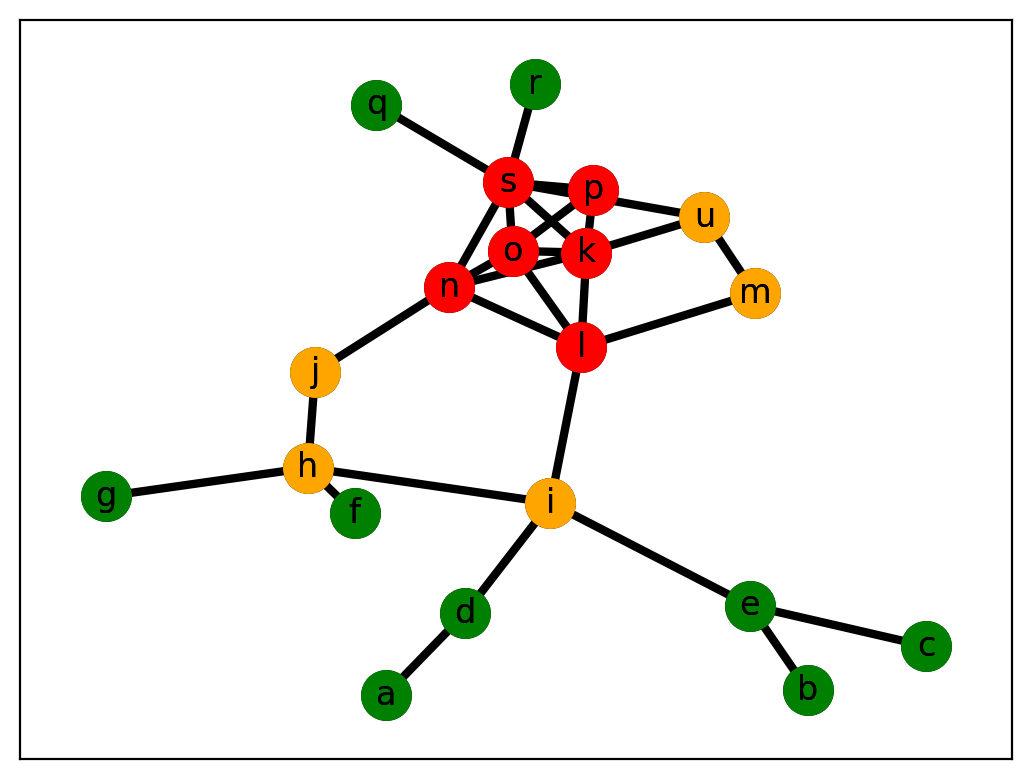

In [79]:
import networkx as nx
from matplotlib import pylab as pl


pos = nx.spring_layout(G0) 

nx.draw_networkx(G0, **options, pos=pos)

k_shell_1 = G0.subgraph(list(nx.k_shell(G0, 1)))

k_shell_2 = G0.subgraph(list(nx.k_shell(G0, 2)))

k_shell_3 = G0.subgraph(list(nx.k_shell(G0, 3)))

nx.draw_networkx(k_shell_1, pos=pos, node_color = 'green')
nx.draw_networkx(k_shell_2, pos=pos, node_color = 'orange')
nx.draw_networkx(k_shell_3, pos=pos, node_color = 'r')

pl.show()